In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from scipy.constants import c as speed_of_light
from scipy.integrate import simpson 
from tqdm import tqdm
import prodimopy.read as pread
from numba import njit
from scipy.stats import kendalltau, spearmanr, pearsonr

In [2]:
@njit
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / ((wl * 1e-4) ** 2)) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux


def plot_prodimo_specie(dataframe, specie, xrange=(5, 28), num_xticks=5, yrange=(0, 0.02), num_yticks=5, savename=None):
    '''
    Plots the spectrum of a specific specie for all the models
    '''
    fig = plt.figure(figsize=(14, 14))
    gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row').flatten()
    for i, row in dataframe.iterrows():
        n_row, n_col = divmod(i, 5)
        axes[i].plot(row['ProDiMo Wavelength'], row[f'ProDiMo {specie}'], label=row['Model Name'])
        axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.05, yrange[0] + (yrange[1] - yrange[0]) * 0.8,
                     f"C={row['C Value']} O={row['O Value']} CO={row['CO Value']} \nFlux={total_flux(row['ProDiMo Wavelength'], row[f'ProDiMo {specie}']):.1e}",
                     fontsize=10, color='red',
                     weight='bold')
        axes[i].set_xlim(xrange)
        axes[i].set_ylim(yrange)
        if n_row == 4:
            axes[i].set_xlabel(r"Wavelength ($\mu$m)")  # Bottom row
            axes[i].set_xticks(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
            axes[i].set_xticklabels(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
        if n_col == 0:
            axes[i].set_ylabel("Flux (Jy)")
            axes[i].set_yticks(np.linspace(yrange[0] * 1000, yrange[1] * 1000, num_yticks, dtype=int)[:-1] / 1000)
            axes[i].set_yticklabels(np.linspace(yrange[0] * 1000, yrange[1] * 1000, num_yticks, dtype=int)[:-1] / 1000)
    fig.suptitle(specie, fontsize=30, fontweight='bold', y=1.02)
    plt.tight_layout()
    if savename:
        plt.savefig(savename)
    plt.show()


def plot_FLiTs_spec(df, xrange=(5, 28), num_xticks=5, yrange=(0, 0.12), num_yticks=5, savename=None):
    '''
    Plots the spectrum of a specific specie for all the models
    '''
    fig = plt.figure(figsize=(13, 13))
    gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row').flatten()
    for i, row in df.iterrows():
        n_row, n_col = divmod(i, 5)
        axes[i].plot(row['FLiTs Wavelength'], row['FLiTs Flux'], label=row['Model Name'])
        axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.05, yrange[0] + (yrange[1] - yrange[0]) * 0.8,
                     f"C={row['C Value']} O={row['O Value']} C/O={row['CO Value']}",
                     fontsize=10, color='red',
                     weight='bold')
        axes[i].set_xlim(xrange)
        axes[i].set_ylim(yrange)
        if n_row == 4:
            axes[i].set_xlabel(r"Wavelength ($\mu$m)")  # Bottom row
            axes[i].set_xticks(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
            axes[i].set_xticklabels(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
        if n_col == 0:
            axes[i].set_ylabel("Flux (Jy)")
            axes[i].set_yticks(np.linspace(yrange[0] * 1000, yrange[1] * 1000, num_yticks, dtype=int)[:-1] / 1000)
            axes[i].set_yticklabels(np.linspace(yrange[0] * 1000, yrange[1] * 1000, num_yticks, dtype=int)[:-1] / 1000)
    plt.tight_layout()
    if savename:
        plt.savefig(savename)
    plt.show()


def plot_prodimo_spec(df, model,
                      species=('C2H2_H', 'CH4_H', 'CO', 'CO2_H', 'HCN_H', 'NH3_H', 'NO_H', 'OH', 'o-H2', 'o-H2O',
                               'p-H2', 'p-H2O', 'Ion'), xrange=(5, 28), yrange=(0, 0.04), plotFLiTs=False):
    """
    Plots the total spectrum predicted by prodimo
    """
    total_spec = None
    cmap = mpl.colormaps.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(14, 5))
    for index, specie in enumerate(species):
        if total_spec is None:
            total_spec = df.loc[df['Model Name'] == model, f'ProDiMo {specie}'].values[0].copy()
        else:
            total_spec += df.loc[df['Model Name'] == model, f'ProDiMo {specie}'].values[0].copy()
        ax.fill_between(df['ProDiMo Wavelength'][0], 0, total_spec, label=specie, zorder=len(species) - index,
                        color=cmap(index / len(species)))
    if plotFLiTs:
        ax.plot(df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy(),
                df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy(), label='FLiTs', color='black',
                zorder=20)
    fig.suptitle(model)
    ax.set_ylabel('Flux [Jy]')
    ax.set_xlabel(r'Wavelength [$\mu$m]')
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    ax.legend(loc='best')
    plt.show()
    
def plot_flits_specie(specie):
    data = []
    for model in df['Model Name'].copy():
        info = []
        info.append(model)
        model_flits = pread.read_FLiTs(f'./FLiTs/{specie}/'+model, filename=f'specFLiTs1_{specie}.out')
        info.append(model_flits.wl)
        info.append(model_flits.flux- model_flits.flux_cont)
        data.append(info)
    
    specie_df = pd.DataFrame(data, columns=['Model Name', 'FLiTs Wavelength', 'FLiTs Flux'])
    fig = plt.figure(figsize=(13, 13))
    gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row').flatten()
    xrange=[5, 28]
    yrange=[0,.1]
    num_xticks = 5
    num_yticks = 5
    for i, row in specie_df.iterrows():
        n_row, n_col = divmod(i, 5)
        axes[i].plot(row['FLiTs Wavelength'], row['FLiTs Flux'], label=row['Model Name'], lw=1)
        # axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.05, yrange[0] + (yrange[1] - yrange[0]) * 0.9,
        #              row['Model Name'],
        #              fontsize=10, color='red',
        #              weight='bold')
        axes[i].set_xlim(xrange)
        # axes[i].set_ylim(yrange)
        if n_row == 4:
            axes[i].set_xlabel(r"Wavelength ($\mu$m)")  # Bottom row
            axes[i].set_xticks(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
            axes[i].set_xticklabels(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
        if n_col == 0:
            axes[i].set_ylabel("Flux (Jy)")
            # axes[i].set_yticks(np.linspace(yrange[0] * 10, yrange[1] * 10, num_yticks, dtype=int)[:-1] / 10)
            # axes[i].set_yticklabels(np.linspace(yrange[0] * 10, yrange[1] * 10, num_yticks, dtype=int)[:-1] / 10)
    plt.tight_layout()
    plt.savefig(f'./figures/{specie}_FLiTs.pdf')
    plt.show()

@njit
def calc_flux(wl, flux, wlrange):
    """
    Calculates the flux of a flux density in Jy over a range of wavelengths in microns
    """
    mask = (wl >= wlrange[0]) & (wl <= wlrange[1])
    return total_flux(wl[mask], flux[mask])
    

# Opening the Data

In [7]:
# Open the data 
with open('FLiTsData1000.pkl', 'rb') as f:
    df = pickle.load(f)
df.head()

,Model Name,C Value,O Value,CO Value,FLiTs Wavelength,FLiTs Flux,FLiTs atomic Flux,FLiTs atomic Wavelength,FLiTs CH4 Flux,FLiTs CH4 Wavelength,...,FLiTs HCN Flux,FLiTs HCN Wavelength,FLiTs NH3 Flux,FLiTs NH3 Wavelength,FLiTs NO Flux,FLiTs NO Wavelength,FLiTs O2 Flux,FLiTs O2 Wavelength,FLiTs OH Flux,FLiTs OH Wavelength
0,C_-0.5_O_-0.5_CO_0.45,-0.5,-0.5,0.45,"[4.90216873, 4.90218508, 4.90220144, 4.9022177...","[0.0009643296611260843, 0.0009735034849698287,...","[-1.3877787807814457e-16, -1.1102230246251565e...","[4.91004966, 4.91006604, 4.91008242, 4.9100988...","[0.0, 0.0, 0.0, 5.551115123125783e-17, 1.11022...","[5.83017478, 5.83019423, 5.83021367, 5.8302331...",...,"[1.6127580613201076e-06, 1.6153986874267723e-0...","[6.28443468, 6.28445564, 6.2844766, 6.28449757...","[5.551115123125783e-17, -1.1102230246251565e-1...","[4.92191407, 4.92193049, 4.92194691, 4.9219633...","[2.8186461475343538e-05, 2.8899044866553814e-0...","[4.94498186, 4.94499836, 4.94501485, 4.9450313...","[-1.1102230246251565e-16, -1.1102230246251565e...","[5.82143071, 5.82145013, 5.82146955, 5.8214889...","[3.839822426687789e-08, 3.914706903085374e-08,...","[5.04256821, 5.04258503, 5.04260185, 5.0426186..."
1,C_-0.5_O_-0.25_CO_0.2570,-0.5,-0.25,0.2570,"[4.90218508, 4.90220144, 4.90221779, 4.9022341...","[0.004067687708073475, 0.0040748347712056265, ...","[-8.326672684688674e-17, -8.326672684688674e-1...","[4.9100988, 4.91011517, 4.91013155, 4.91014793...","[-2.7755575615628914e-16, -3.885780586188048e-...","[5.83017478, 5.83019423, 5.83021367, 5.8302331...",...,"[8.603044766575252e-07, 8.61788779504824e-07, ...","[6.28443468, 6.28445564, 6.2844766, 6.28449757...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6653345369377...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[5.455045169738826e-05, 5.57964574059433e-05, ...","[4.94499836, 4.94501485, 4.94503135, 4.9450478...","[2.7755575615628914e-16, 2.7755575615628914e-1...","[5.82146955, 5.82148897, 5.82150839, 5.8215278...","[8.642852605822426e-08, 8.852198368769493e-08,...","[5.04258503, 5.04260185, 5.04261867, 5.0426354..."
2,C_-0.5_O_0.0_CO_0.145,-0.5,0.0,0.145,"[4.90221779, 4.90222315, 4.9022395, 4.90225585...","[0.006994756799092228, 0.00699622903455438, 0....","[0.0, 0.0, 2.7755575615628914e-17, 5.551115123...","[4.91018069, 4.91019707, 4.91021345, 4.9102298...","[1.1102230246251565e-16, 2.220446049250313e-16...","[5.83017478, 5.83019423, 5.83021367, 5.8302331...",...,"[4.08216717651122e-07, 4.088461126317e-07, 4.0...","[6.28445564, 6.2844766, 6.28449757, 6.28451853...","[0.0, 0.0, 0.0, -5.551115123125783e-17, -5.551...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[8.98434293424566e-05, 9.179616055002282e-05, ...","[4.94501485, 4.94503135, 4.94504784, 4.9450643...","[1.6653345369377348e-16, 1.6653345369377348e-1...","[5.82148897, 5.82150839, 5.82152781, 5.8215472...","[2.2606257266133412e-07, 2.300231963792143e-07...","[5.04258503, 5.04260185, 5.04261867, 5.0426354..."
3,C_-0.5_O_0.25_CO_0.0813,-0.5,0.25,0.0813,"[4.9022395, 4.90225585, 4.9022722, 4.90228855,...","[0.010322807927214295, 0.010317067430515525, 0...","[2.7755575615628914e-17, 2.7755575615628914e-1...","[4.91027896, 4.91029534, 4.91031172, 4.9103281...","[2.220446049250313e-16, 2.220446049250313e-16,...","[5.83017478, 5.83019423, 5.83021367, 5.8302331...",...,"[1.6788144285850848e-07, 1.682061885888153e-07...","[6.28445564, 6.2844766, 6.28449757, 6.28451853...","[2.7755575615628914e-16, 0.0, -5.5511151231257...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[0.00012909757029855307, 0.0001318028760430856...","[4.94504784, 4.94506434, 4.94508083, 4.9450973...","[6.38626929116981e-11, 6.583755762790133e-11, ...","[5.82150839, 5.82152781, 5.82154722, 5.8215666...","[3.1542691703023706e-07, 3.2251283543782705e-0...","[5.04261867, 5.04263549, 5.04265231, 5.0426691..."
4,C_-0.5_O_0.5_CO_0.045,-0.5,0.5,0.045,"[4.90225585, 4.9022722, 4.90228855, 4.90230491...","[0.008905396890832917, 0.00890696426121479, 0....","[0.0, 2.7755575615628914e

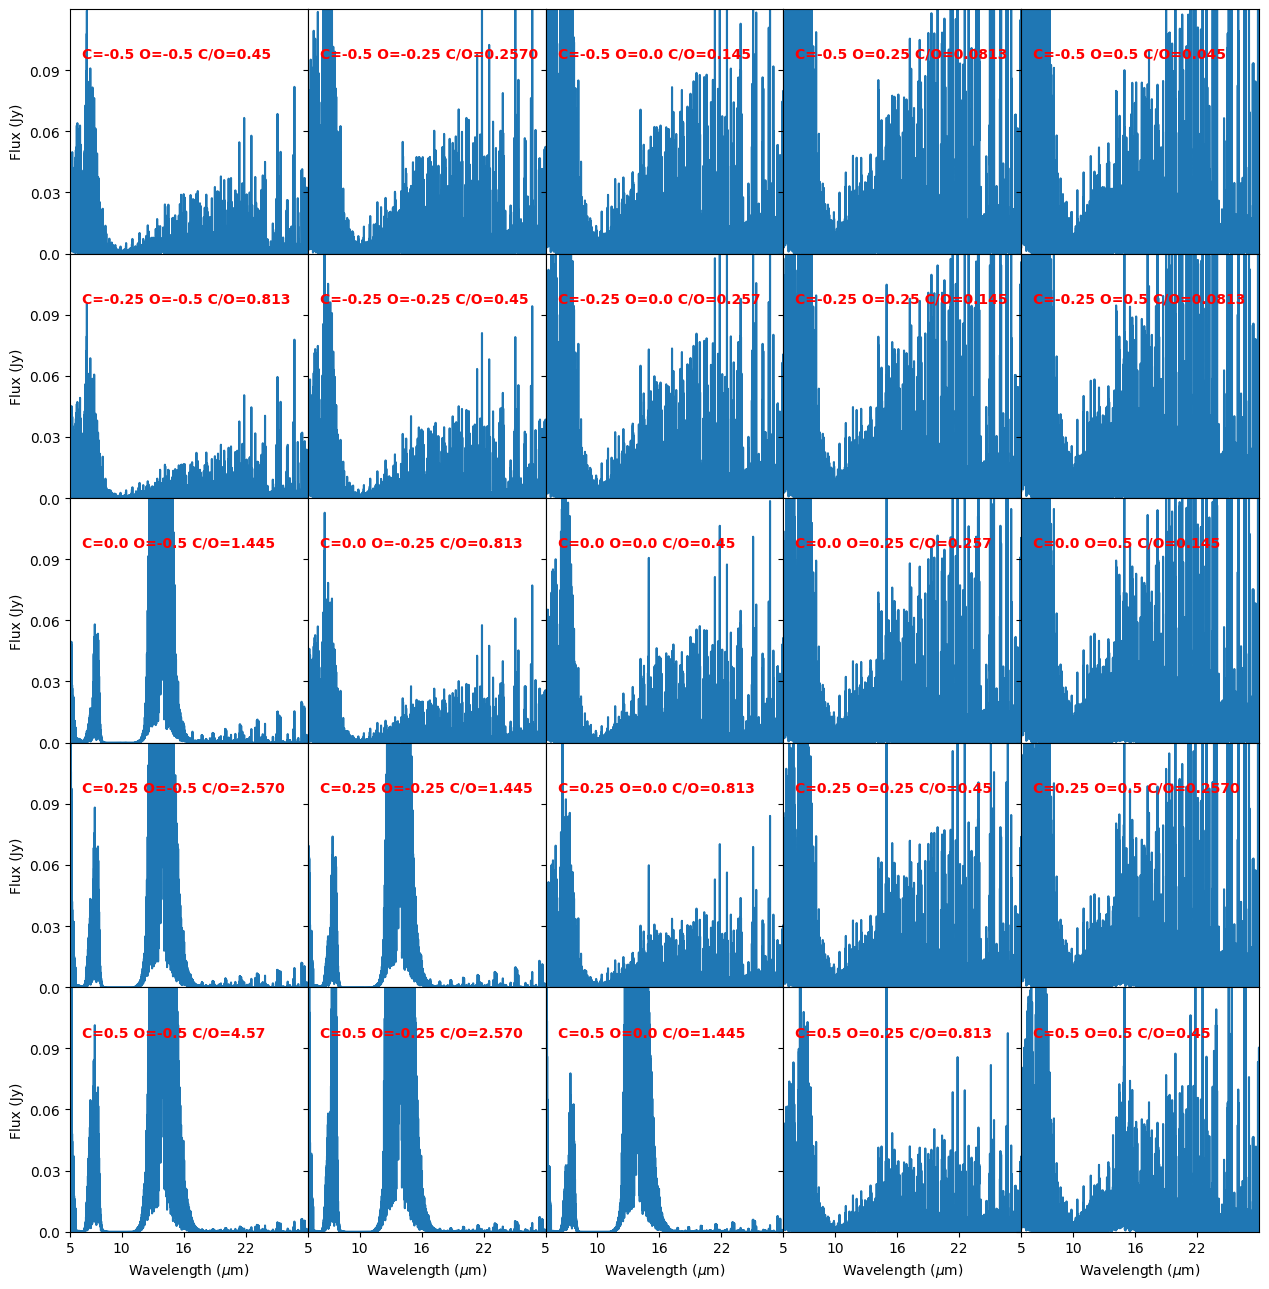

In [4]:
plot_FLiTs_spec(df)

# Prodimo Spectra
escape probability


In [ ]:
plt.close('all')
species = ['C2H2_H', 'CH4_H', 'CO', 'CO2_H', 'HCN_H', 'NH3_H', 'NO_H', 'OH', 'o-H2', 'o-H2O', 'p-H2', 'p-H2O',
           'atomic']
species = ['CH4_H']
for specie in species:
    plot_prodimo_specie(df, specie)

In [12]:
# plt.close('all')
# species = ['C2H2_H', 'CH4_H', 'CO', 'CO2_H', 'HCN_H', 'NH3_H', 'NO_H', 'OH', 'S', 'o-H2', 'o-H2O', 'p-H2', 'p-H2O',
#            'Ion']
# # species = ['C2H2_H']
# for specie in species:
#     fig = plt.figure(figsize=(15, 15))
#     gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
#     axes = gs.subplots(sharex='col', sharey='row').flatten()
#     for i, row in df.iterrows():
#         n_row, n_col = divmod(i, 5)
#         axes[i].plot(row['Prodimo Wavelength'], row[specie], label=row['Model Name'])
#         axes[i].text(wlrange[0] + (wlrange[1] - wlrange[0]) * 0.05, 0.9*flux_lim,
#                      f"C={row['C Value']} O={row['O Value']} CO={row['CO Value']} \nFlux={total_flux(row['Prodimo Wavelength'], row[specie]):.1e}", fontsize=10, color='red',
#                      weight='bold')
#         axes[i].set_xlim(wlrange)
#         axes[i].set_ylim([0, flux_lim])
#         if n_row == 4:
#             axes[i].set_xlabel(r"Wavelength ($\mu$m)")  # Bottom row
#             axes[i].set_xticks([6, 12, 18, 24])
#             axes[i].set_xticklabels([6, 12, 18, 24])
#         if n_col == 0:
#             axes[i].set_ylabel("Flux (Jy)")
#             axes[i].set_yticks(np.linspace(0, 0.8*flux_lim, n_yticks))
#             axes[i].set_yticklabels(np.linspace(0, 0.8*flux_lim, n_yticks))
#     fig.suptitle(specie, fontsize=30, fontweight='bold', y=1.02)
#     plt.tight_layout()
#     plt.savefig('figures/' + specie + '_total_spec.pdf')
#     plt.show()

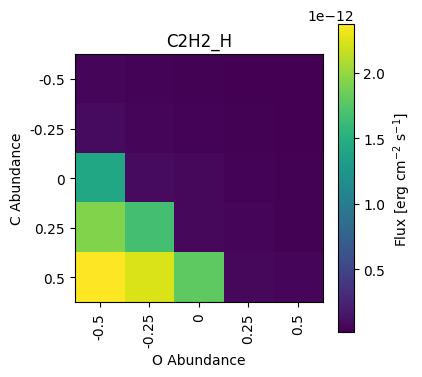

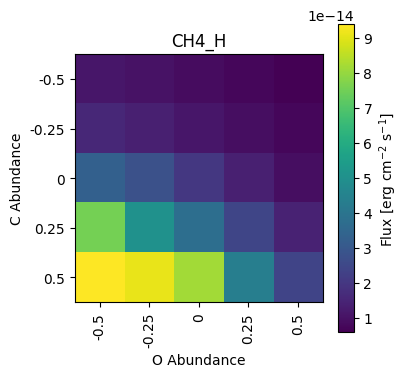

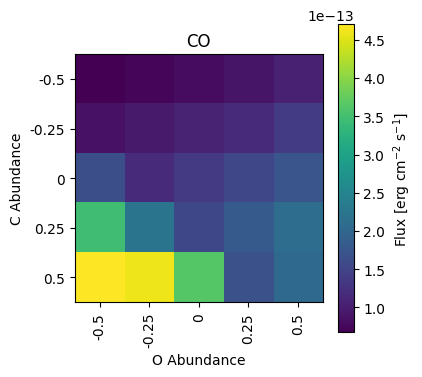

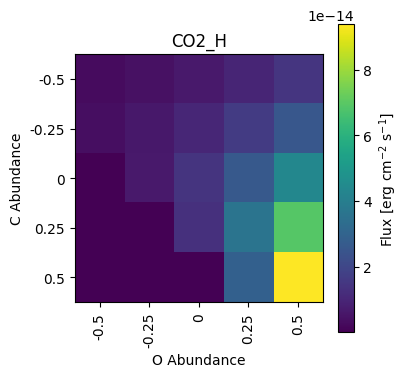

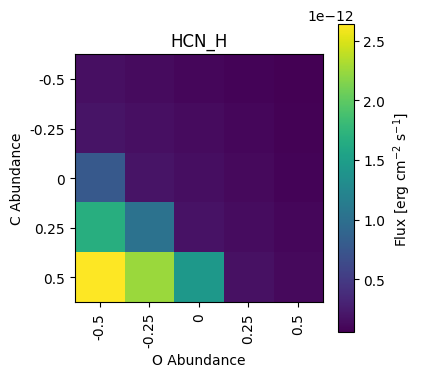

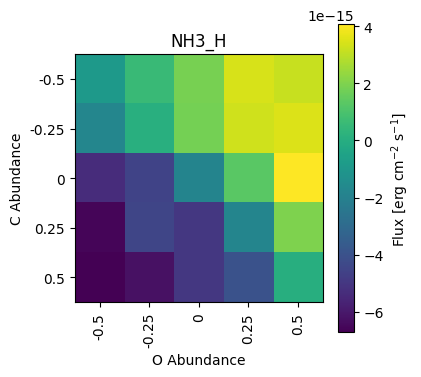

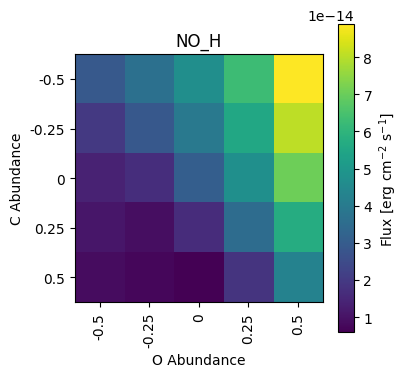

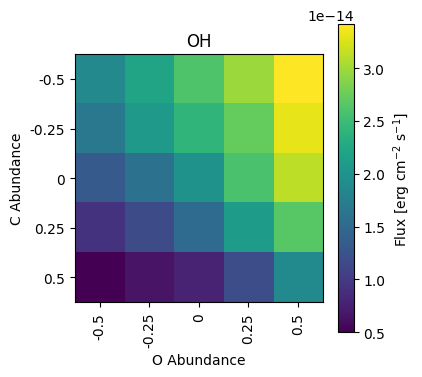

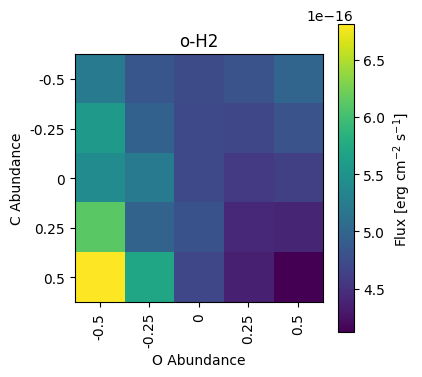

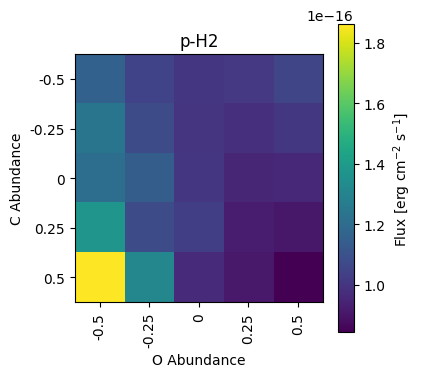

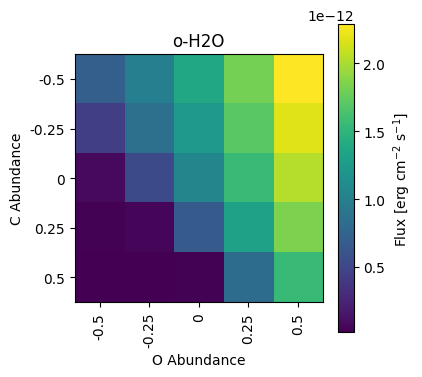

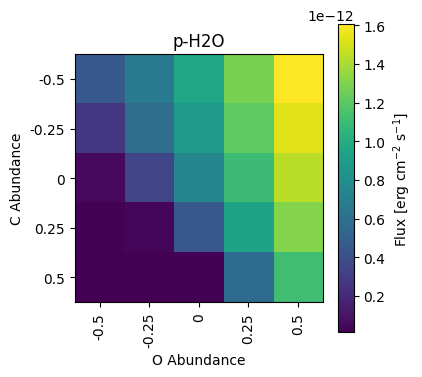

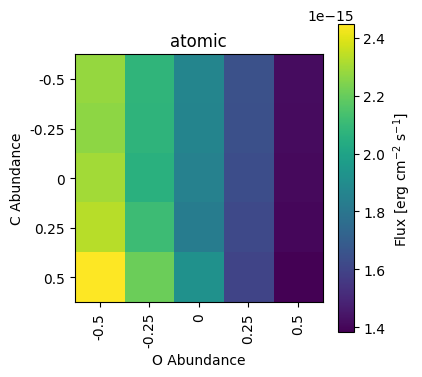

        C2H2_H  CH4_H    CO  CO2_H  HCN_H  NH3_H  NO_H    OH  o-H2  p-H2  \
C2H2_H    1.00   0.83  0.42  -0.49   0.92  -0.83 -0.84 -0.85  0.31  0.33   
CH4_H     0.83   1.00  0.56  -0.33   0.77  -0.77 -0.75 -0.83  0.14  0.17   
CO        0.42   0.56  1.00   0.08   0.34  -0.36 -0.33 -0.42 -0.09 -0.09   
CO2_H    -0.49  -0.33  0.08   1.00  -0.57   0.51  0.53  0.49 -0.70 -0.72   
HCN_H     0.92   0.77  0.34  -0.57   1.00  -0.82 -0.92 -0.89  0.37  0.41   
NH3_H    -0.83  -0.77 -0.36   0.51  -0.82   1.00  0.81  0.85 -0.35 -0.39   
NO_H     -0.84  -0.75 -0.33   0.53  -0.92   0.81  1.00  0.89 -0.33 -0.37   
OH       -0.85  -0.83 -0.42   0.49  -0.89   0.85  0.89  1.00 -0.29 -0.33   
o-H2      0.31   0.14 -0.09  -0.70   0.37  -0.35 -0.33 -0.29  1.00  0.94   
p-H2      0.33   0.17 -0.09  -0.72   0.41  -0.39 -0.37 -0.33  0.94  1.00   
o-H2O    -0.85  -0.69 -0.27   0.64  -0.93   0.77  0.89  0.85 -0.45 -0.48   
p-H2O    -0.85  -0.69 -0.27   0.64  -0.93   0.77  0.89  0.85 -0.45 -0.48   
atomic    0.

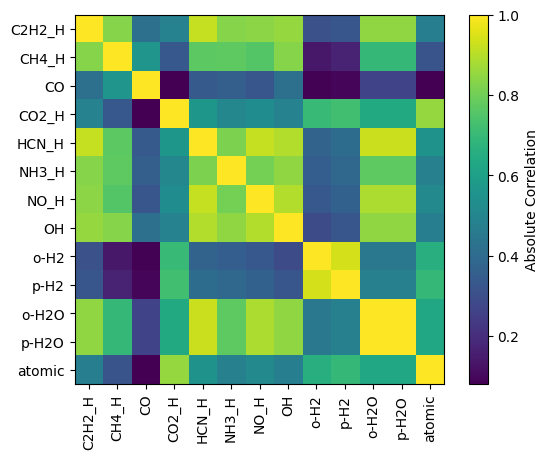

In [14]:
plt.close('all')
species = ['C2H2_H', 'CH4_H', 'CO', 'CO2_H', 'HCN_H', 'NH3_H', 'NO_H', 'OH', 'o-H2', 'p-H2', 'o-H2O', 'p-H2O',
           'atomic']
data = []
for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row['ProDiMo Wavelength'], row[f'ProDiMo {specie}']))
    data.append(fluxes)
df_prodimo_flux = pd.DataFrame(data, columns=species)
for specie in species:
    plt.figure(figsize=(4, 4))
    plt.imshow(df_prodimo_flux[specie].values.reshape(5,5), cmap='viridis')
    plt.title(specie)
    plt.xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    plt.yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
    plt.xlabel('O Abundance')
    plt.ylabel('C Abundance')
    plt.colorbar(label='Flux [erg cm$^{-2}$ s$^{-1}$]')
    plt.show()
print(df_prodimo_flux.corr(method='kendall').round(2))
plt.imshow(abs(df_prodimo_flux.corr(method='kendall')), cmap=plt.get_cmap("viridis")) # method='kendall'
plt.xticks(ticks=np.arange(len(species)), labels=species, rotation=90)
plt.yticks(ticks=np.arange(len(species)), labels=species)
plt.colorbar(label='Absolute Correlation')
plt.show()
# df_prodimo_flux.corr().to_csv('Prodimo_flux_correlation.csv', float_format="%.2f")

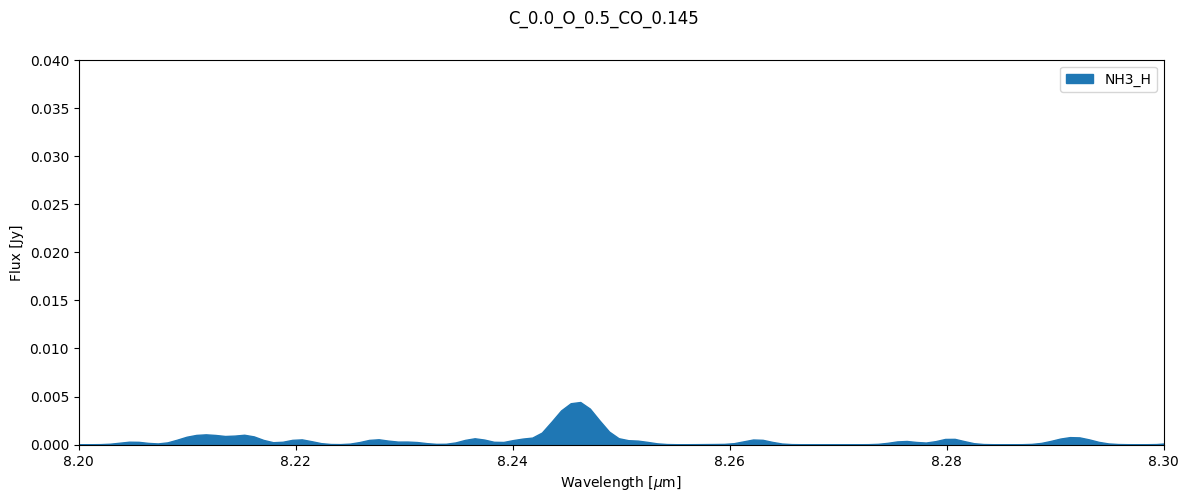

In [15]:
model = df['Model Name'][14]
species = ['C2H2_H', 'CH4_H', 'CO', 'CO2_H', 'HCN_H', 'NH3_H', 'NO_H', 'OH', 'o-H2', 'p-H2', 'o-H2O', 'p-H2O',
           'atomic']
species = ['NH3_H']
plot_prodimo_spec(df, model, species=species, xrange=[8.2,8.3], yrange=[0,0.04], plotFLiTs=False)

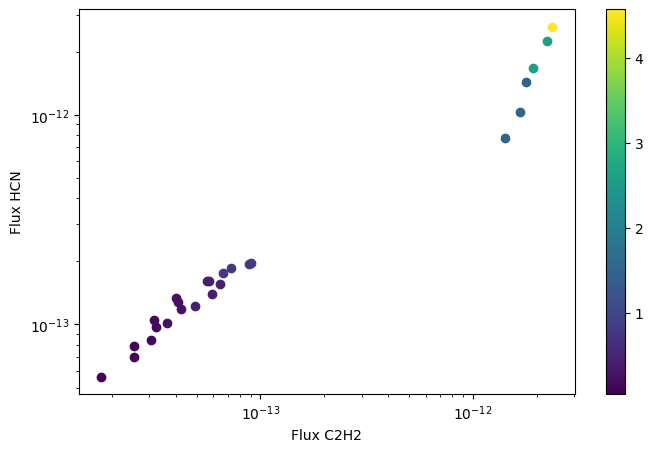

Correlation: 0.9199999999999998, P-value: 1.3817189787340094e-16


In [17]:
x = []
y = []
# norm = plt.Normalize(df_flux['CO'].min(), df_flux['CO'].max())
co_values = np.asarray([float(df.loc[df['Model Name'] == model, 'CO Value'].iloc[0]) for model in df['Model Name'].copy()])
norm = plt.Normalize(co_values.min(), co_values.max())
cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(8, 5))
for model in df['Model Name'].copy():
    wl = df.loc[df['Model Name'] == model, 'ProDiMo Wavelength'].values[0].copy()
    HCN_flux = df.loc[df['Model Name'] == model, 'ProDiMo HCN_H'].values[0].copy()
    C2H2_flux = df.loc[df['Model Name'] == model, 'ProDiMo C2H2_H'].values[0].copy()
    x.append(total_flux(wl, C2H2_flux))
    y.append(total_flux(wl, HCN_flux))
    # y.append(calc_flux(wl, NH3_flux, [5, 9])+ calc_flux(wl, NH3_flux, [12, 18]))
    ax.scatter(x[-1], y[-1], color=cmap(norm(float(df.loc[df['Model Name'] == model, 'CO Value'].iloc[0]))))
ax.set_xlabel('Flux C2H2')
ax.set_ylabel('Flux HCN')
# ax.set_xlim(0, 0.5 * 1e-12)
ax.set_yscale('log')
ax.set_xscale('log')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
plt.show()
x = np.asarray(x)
y = np.asarray(y)

corr, p_value = kendalltau(x, y)
print(f"Correlation: {corr}, P-value: {p_value}")

100%|██████████| 25/25 [00:02<00:00, 12.13it/s]


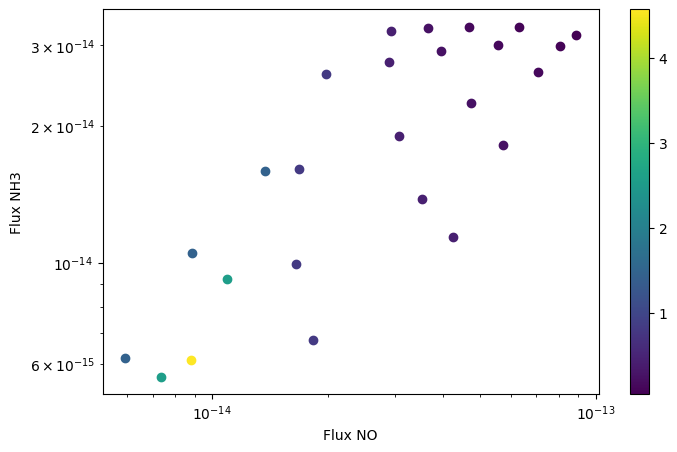

Correlation: 0.5666666666666667, P-value: 3.0830988230961115e-05


In [19]:
x = []
y = []
# norm = plt.Normalize(df_flux['CO'].min(), df_flux['CO'].max())
co_values = np.asarray([float(df.loc[df['Model Name'] == model, 'CO Value'].iloc[0]) for model in df['Model Name'].copy()])
norm = plt.Normalize(co_values.min(), co_values.max())
cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(8, 5))
for model in tqdm(df['Model Name'].copy()):
    wl = df.loc[df['Model Name'] == model, 'ProDiMo Wavelength'].values[0].copy()
    NO_flux = df.loc[df['Model Name'] == model, 'ProDiMo NO_H'].values[0].copy()
    HCN_flux = df.loc[df['Model Name'] == model, 'ProDiMo HCN_H'].values[0].copy()
    NH3_flux = df.loc[df['Model Name'] == model, 'ProDiMo NH3_H'].values[0].copy()
    C2H2_flux = df.loc[df['Model Name'] == model, 'ProDiMo C2H2_H'].values[0].copy()
    CO2_flux = df.loc[df['Model Name'] == model, 'ProDiMo CO2_H'].values[0].copy()
    x.append(total_flux(wl, NO_flux))
    y.append(calc_flux(wl, NH3_flux, [5, 8]))
    # y.append(calc_flux(wl, NH3_flux, [5, 9])+ calc_flux(wl, NH3_flux, [12, 18]))
    ax.scatter(x[-1], y[-1], color=cmap(norm(float(df.loc[df['Model Name'] == model, 'CO Value'].iloc[0]))))
ax.set_xlabel('Flux NO')
ax.set_ylabel('Flux NH3')
# ax.set_xlim(0, 0.5 * 1e-12)
ax.set_yscale('log')
ax.set_xscale('log')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
plt.show()
x = np.asarray(x)
y = np.asarray(y)

from scipy.stats import kendalltau, spearmanr, pearsonr
corr, p_value = kendalltau(x, y)
print(f"Correlation: {corr}, P-value: {p_value}")

# FLiTs Data

In [20]:
# Spectral regions from Anderson et al. 2021
spectral_regions = {r'CO$_2$': [14.874, 15.014], r'C$_2$H$_2$': [13.553, 13.764], 'HCN': [13.837, 14.075],
                    r'H$_2$O': [17.190, 17.260], 'OH \n23 µm': [23.009, 23.308], 'OH \n27 µm': [27.308, 27.764],
                    r'CH$_4$': [5, 11]}
data = []
columns = list(spectral_regions.keys())
columns.extend(['C', 'O','CO'])
for model in tqdm(df['Model Name'].copy()):
    fluxes = []
    for key, value in spectral_regions.items():
        fluxes.append(calc_flux(df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy(), df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy(), value))
    fluxes.append(float(df.loc[df['Model Name'] == model, 'C Value'].values[0]))
    fluxes.append(float(df.loc[df['Model Name'] == model, 'O Value'].values[0]))
    fluxes.append(float(df.loc[df['Model Name'] == model, 'CO Value'].values[0]))
    data.append(fluxes)

df_flux = pd.DataFrame(data, columns=columns)

100%|██████████| 25/25 [00:02<00:00, 10.61it/s]


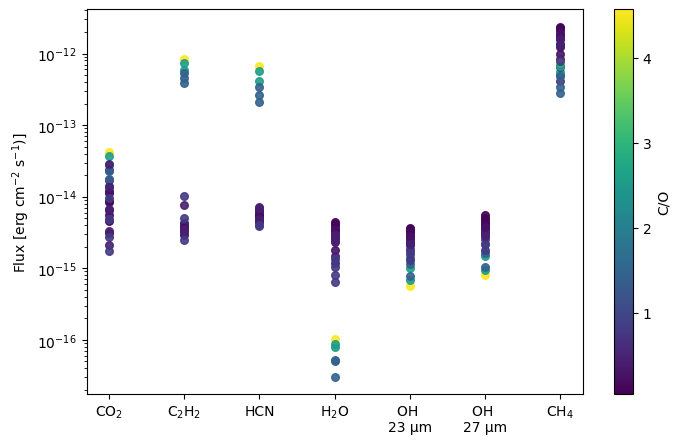

In [21]:
specie = 'CO'
norm = plt.Normalize(df_flux[specie].min(), df_flux[specie].max())
cmap = plt.cm.viridis

# Plot each column with colors based on the last column
fig, ax = plt.subplots(figsize=(8, 5))

for i, row in df_flux.iterrows():
    ax.scatter(np.arange(len(columns[:-3])), row[:-3], color=cmap(norm(row[specie])), alpha=0.9, s=30)

ax.set_xticks(np.arange(len(columns[:-3])))
ax.set_xticklabels(columns[:-3]) 
ax.set_yscale('log')
# Formatting
# ax.set_xlabel('Index')
ax.set_ylabel(r'Flux [erg cm$^{-2}$ s$^{-1}$)]')
# plt.title('Plot with Colormap Based on Last Column')
# plt.legend()
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('C/O')

plt.show()

              CO$_2$  C$_2$H$_2$       HCN    H$_2$O  OH \n23 µm  OH \n27 µm  \
CO$_2$      1.000000    0.140000  0.453333  0.013333   -0.200000   -0.293333   
C$_2$H$_2$  0.140000    1.000000  0.686667 -0.366667   -0.393333   -0.340000   
HCN         0.453333    0.686667  1.000000 -0.253333   -0.346667   -0.333333   
H$_2$O      0.013333   -0.366667 -0.253333  1.000000    0.773333    0.666667   
OH \n23 µm -0.200000   -0.393333 -0.346667  0.773333    1.000000    0.893333   
OH \n27 µm -0.293333   -0.340000 -0.333333  0.666667    0.893333    1.000000   
CH$_4$      0.093333   -0.286667 -0.173333  0.906667    0.693333    0.586667   

              CH$_4$  
CO$_2$      0.093333  
C$_2$H$_2$ -0.286667  
HCN        -0.173333  
H$_2$O      0.906667  
OH \n23 µm  0.693333  
OH \n27 µm  0.586667  
CH$_4$      1.000000  


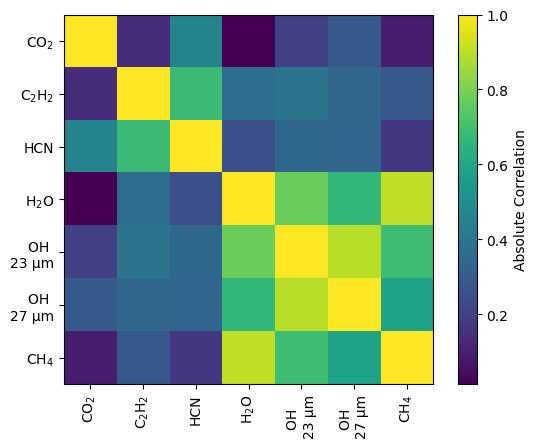

In [22]:
correlation_matrix = df_flux[list(spectral_regions.keys())].corr(method='kendall')
print(correlation_matrix)
plt.imshow(abs(correlation_matrix), cmap=plt.get_cmap("viridis")) # method='kendall'
plt.xticks(ticks=np.arange(len(columns[:-3])), labels=columns[:-3], rotation=90)
plt.yticks(ticks=np.arange(len(columns[:-3])), labels=columns[:-3])
plt.colorbar(label='Absolute Correlation')
plt.show()

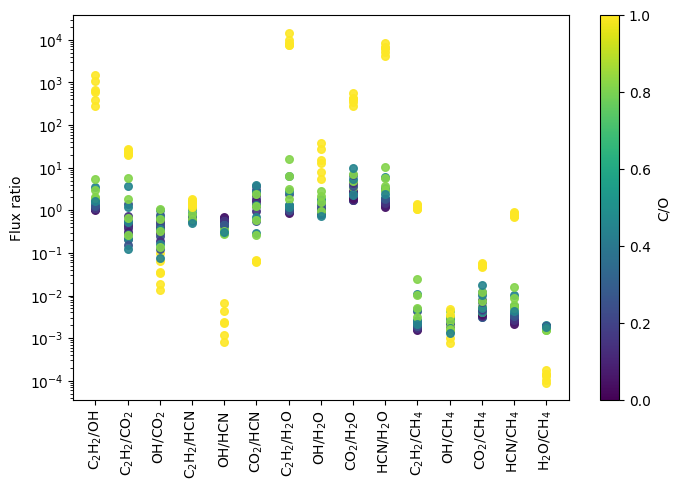

In [23]:
specie = 'CO'
norm = plt.Normalize(0, 1)
cmap = plt.cm.viridis

# Plot each column with colors based on the last column
fig, ax = plt.subplots(figsize=(8, 5))
ratios = ['C$_2$H$_2$/OH \n23 µm', 'C$_2$H$_2$/CO$_2$', 'OH \n23 µm/CO$_2$', 'C$_2$H$_2$/HCN', 'OH \n23 µm/HCN', 'CO$_2$/HCN', 'C$_2$H$_2$/H$_2$O', 'OH \n23 µm/H$_2$O', 'CO$_2$/H$_2$O', 'HCN/H$_2$O', 'C$_2$H$_2$/CH$_4$', 'OH \n23 µm/CH$_4$', 'CO$_2$/CH$_4$', 'HCN/CH$_4$', 'H$_2$O/CH$_4$']

for i, row in df_flux.iterrows():
    for index, ratio in enumerate(ratios):
        ax.scatter(np.arange(len(ratios))[index], row[ratio.split('/')[0]]/row[ratio.split('/')[1]], color=cmap(norm(row[specie])), alpha=0.9, s=30)

ratio_names = ['C$_2$H$_2$/OH', 'C$_2$H$_2$/CO$_2$', 'OH/CO$_2$', 'C$_2$H$_2$/HCN', 'OH/HCN', 'CO$_2$/HCN', 'C$_2$H$_2$/H$_2$O', 'OH/H$_2$O', 'CO$_2$/H$_2$O', 'HCN/H$_2$O', 'C$_2$H$_2$/CH$_4$', 'OH/CH$_4$', 'CO$_2$/CH$_4$', 'HCN/CH$_4$', 'H$_2$O/CH$_4$']
ax.set_xticks(np.arange(len(ratios)))
ax.set_xticklabels(ratio_names, rotation=90) 
ax.set_yscale('log')
# Formatting
# ax.set_xlabel('Index')
ax.set_ylabel(r'Flux ratio')
# plt.title('Plot with Colormap Based on Last Column')
# plt.legend()
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('C/O')

plt.show()

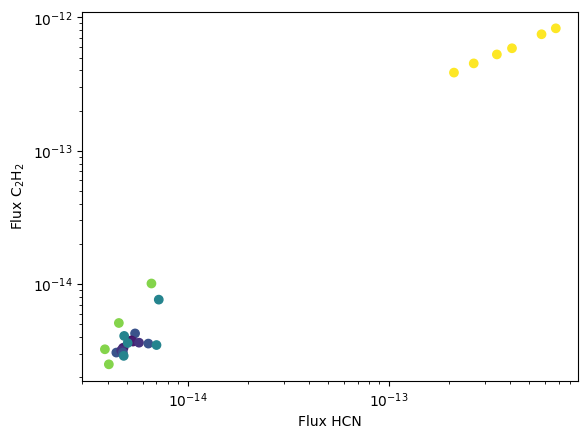

In [24]:
plt.scatter(df_flux['HCN'], df_flux['C$_2$H$_2$'], color=cmap(norm(df_flux['CO'])))
plt.xlabel('Flux HCN')
plt.ylabel('Flux C$_2$H$_2$')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[5, 28]
yrange=[0, 0.001]
num_xticks = 5
num_yticks = 5
for i, row in df.iterrows():
    n_row, n_col = divmod(i, 5)
    total_FLiTs_flux = df.loc[df['Model Name'] == row['Model Name'], 'FLiTs Flux'].values[0].copy()
    total_FLiTs_wl = df.loc[df['Model Name'] == row['Model Name'], 'FLiTs Wavelength'].values[0].copy()
    interp_NH3_flux = np.interp(total_FLiTs_wl, row['FLiTs NH3 Wavelength'], row['FLiTs NH3 Flux'])
    axes[i].plot(total_FLiTs_wl, (interp_NH3_flux+1)/(total_FLiTs_flux+1), lw=1)
    # axes[i].plot(total_FLiTs_wl, interp_NH3_flux, lw=1)
    # axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.05, yrange[0] + (yrange[1] - yrange[0]) * 0.9,
    #              row['Model Name'],
    #              fontsize=10, color='red',
    #              weight='bold')
    # axes[i].set_xlim(xrange)
    axes[i].set_ylim([0.99999, 1.0001])
    if n_row == 4:
        axes[i].set_xlabel(r"Wavelength ($\mu$m)")  # Bottom row
        # axes[i].set_xticks(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
        # axes[i].set_xticklabels(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
    if n_col == 0:
        axes[i].set_ylabel("Flux")
        # axes[i].set_yticks(np.linspace(yrange[0] * 10, yrange[1] * 10, num_yticks, dtype=int)[:-1] / 10)
        # axes[i].set_yticklabels(np.linspace(yrange[0] * 10, yrange[1] * 10, num_yticks, dtype=int)[:-1] / 10)
plt.tight_layout()
plt.show()

In [ ]:
l = ['atomic', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
for n in l:
    plot_flits_specie(n)

READ: Reading File:  ./FLiTs/CO/C_-0.5_O_-0.5_CO_0.45\specFLiTs1_CO.out  ...
READ: Reading File:  ./FLiTs/CO/C_-0.5_O_-0.25_CO_0.2570\specFLiTs1_CO.out  ...
READ: Reading File:  ./FLiTs/CO/C_-0.5_O_0.0_CO_0.145\specFLiTs1_CO.out  ...
READ: Reading File:  ./FLiTs/CO/C_-0.5_O_0.25_CO_0.0813\specFLiTs1_CO.out  ...
READ: Reading File:  ./FLiTs/CO/C_-0.5_O_0.5_CO_0.045\specFLiTs1_CO.out  ...
READ: Reading File:  ./FLiTs/CO/C_-0.25_O_-0.5_CO_0.813\specFLiTs1_CO.out  ...
READ: Reading File:  ./FLiTs/CO/C_-0.25_O_-0.25_CO_0.45\specFLiTs1_CO.out  ...
READ: Reading File:  ./FLiTs/CO/C_-0.25_O_0.0_CO_0.257\specFLiTs1_CO.out  ...
READ: Reading File:  ./FLiTs/CO/C_-0.25_O_0.25_CO_0.145\specFLiTs1_CO.out  ...
READ: Reading File:  ./FLiTs/CO/C_-0.25_O_0.5_CO_0.0813\specFLiTs1_CO.out  ...
READ: Reading File:  ./FLiTs/CO/C_0.0_O_-0.5_CO_1.445\specFLiTs1_CO.out  ...
READ: Reading File:  ./FLiTs/CO/C_0.0_O_-0.25_CO_0.813\specFLiTs1_CO.out  ...
READ: Reading File:  ./FLiTs/CO/C_0.0_O_0.0_CO_0.45\specFLiTs

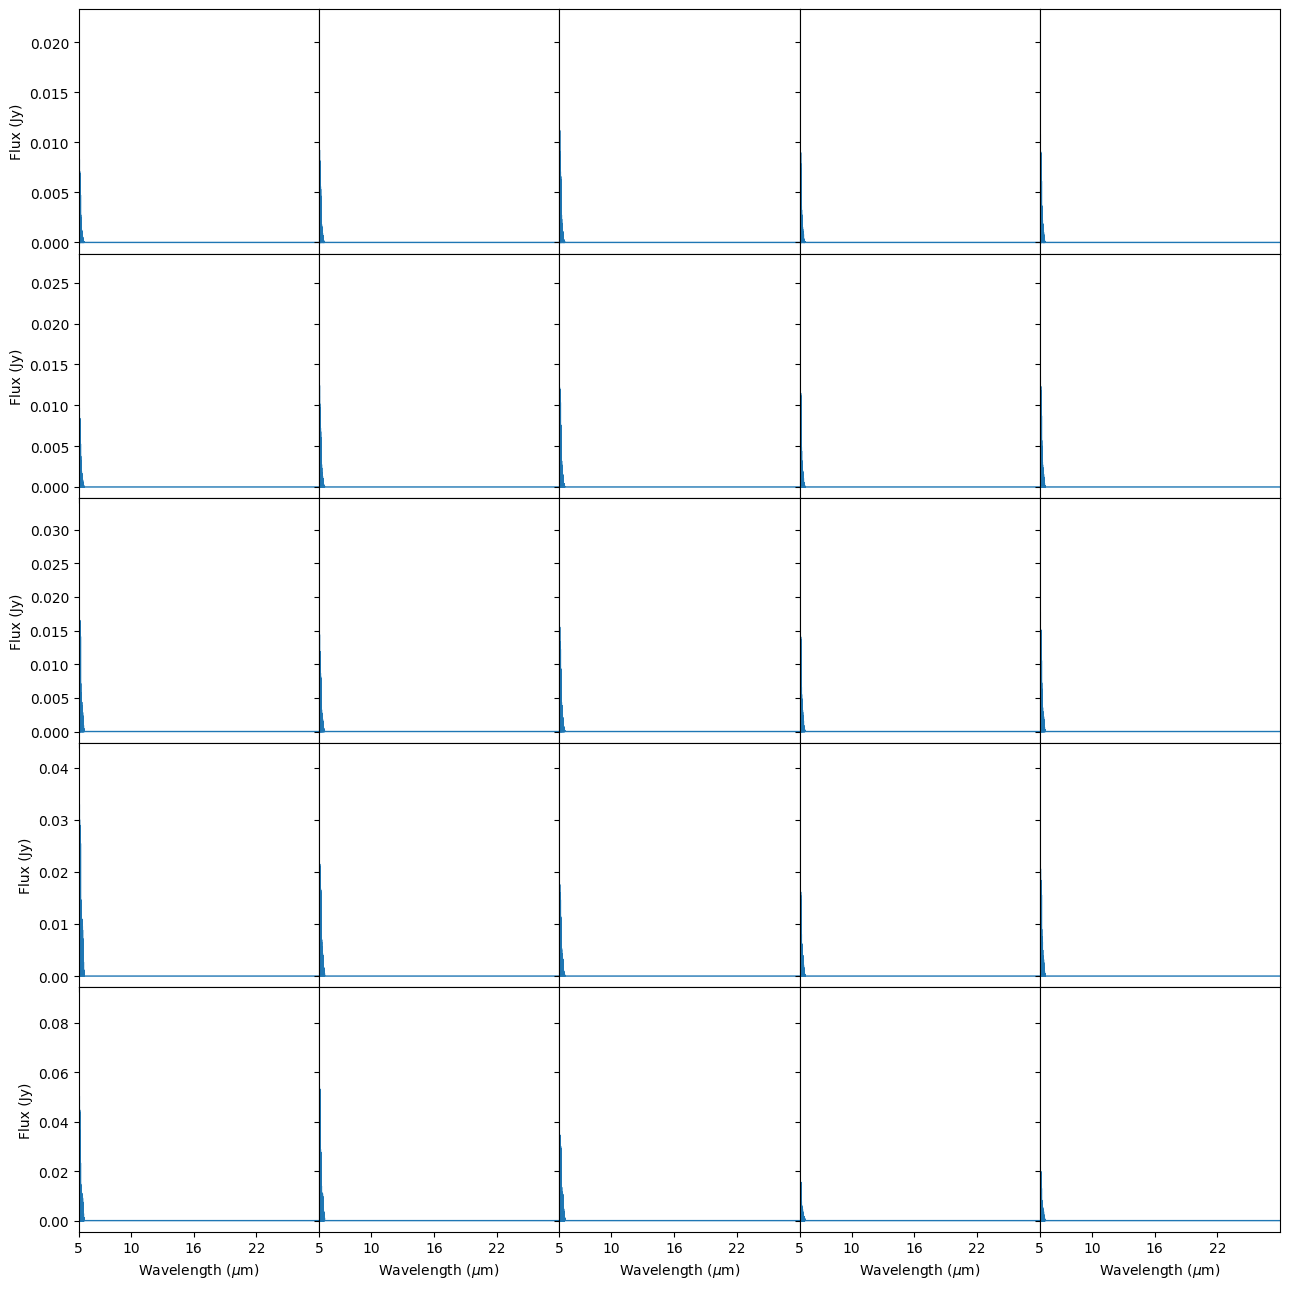

In [25]:
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[5, 28]
yrange=[0,.1]

data = []
for model in df['Model Name'].copy():
    info = []
    info.append(model)
    model_flits = pread.read_FLiTs(f'./FLiTs/{specie}/'+model, filename=f'specFLiTs1_{specie}.out')
    info.append(model_flits.wl)
    info.append(model_flits.flux- model_flits.flux_cont)
    data.append(info)

specie_df = pd.DataFrame(data, columns=['Model Name', 'FLiTs Wavelength', 'FLiTs Flux'])
num_xticks = 5
num_yticks = 5
for i, row in specie_df.iterrows():
    n_row, n_col = divmod(i, 5)
    axes[i].plot(row['FLiTs Wavelength'], row['FLiTs Flux'], label=row['Model Name'], lw=1)
    # axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.05, yrange[0] + (yrange[1] - yrange[0]) * 0.9,
    #              row['Model Name'],
    #              fontsize=10, color='red',
    #              weight='bold')
    axes[i].set_xlim(xrange)
    axes[i].set_ylim(yrange)
    if n_row == 4:
        axes[i].set_xlabel(r"Wavelength ($\mu$m)")  # Bottom row
        axes[i].set_xticks(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
        axes[i].set_xticklabels(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
    if n_col == 0:
        axes[i].set_ylabel("Flux (Jy)")
        # axes[i].set_yticks(np.linspace(yrange[0] * 10, yrange[1] * 10, num_yticks, dtype=int)[:-1] / 10)
        # axes[i].set_yticklabels(np.linspace(yrange[0] * 10, yrange[1] * 10, num_yticks, dtype=int)[:-1] / 10)
plt.tight_layout()
plt.savefig(f'./figures/{specie}_FLiTs.pdf')
plt.show()

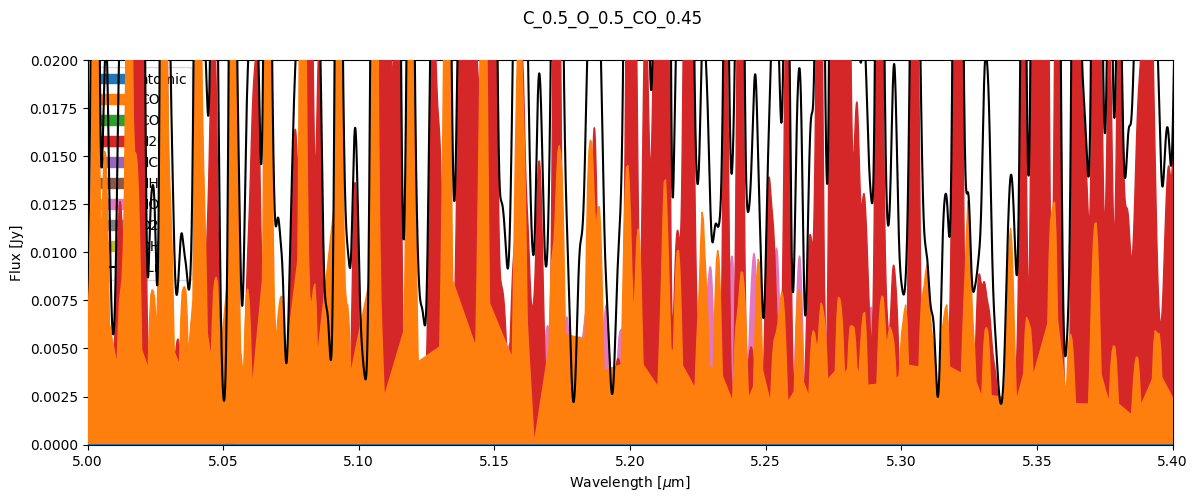

In [9]:
cmap = mpl.colormaps.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(14, 5))
species = ['atomic', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
model = df['Model Name'][24]
for index, specie in enumerate(species):
    ax.fill_between(df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy(), 0, df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy(), label=specie, zorder=len(species) - index,
                    color=cmap(index / len(species)))
ax.plot(df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy(),
        df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy(), label='FLiTs', color='black',
        zorder=20)
fig.suptitle(model)
ax.set_ylabel('Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim([5, 5.4])
ax.set_ylim(0,0.02)
ax.legend(loc='best')
plt.show()

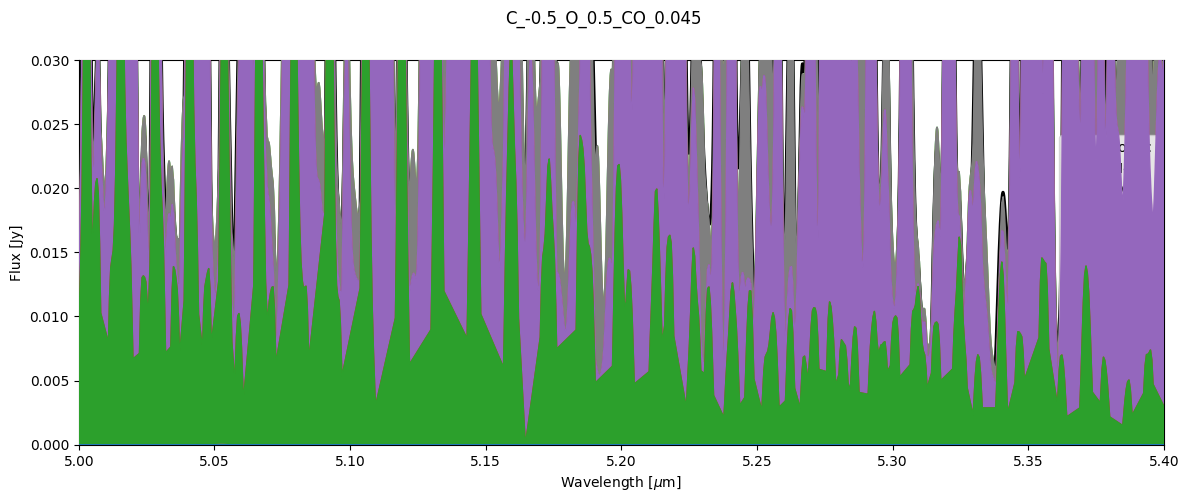

In [10]:
total_spec = None
cmap = mpl.colormaps.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(14, 5))
species = ['atomic', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
model = df['Model Name'][4]
FLiTs_wl = df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy()
FLiTs_flux = df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy()
for index, specie in enumerate(species):
    specie_wl = df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy()
    specie_flux = df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()
    new_specie_flux = np.interp(FLiTs_wl, specie_wl, specie_flux, left=0, right=0)
    if total_spec is None:
        total_spec = new_specie_flux
    else:
        total_spec += new_specie_flux
    ax.fill_between(FLiTs_wl, 0, total_spec, label=specie, zorder=len(species) - index,
                    color=cmap(index / len(species)))
ax.plot(FLiTs_wl, FLiTs_flux, c='black', lw=2, label='FLiTs')
specie = 'CO'
specie_wl = df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy()
specie_flux = df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()
# ax.plot(specie_wl, specie_flux)
fig.suptitle(model)
ax.set_ylabel('Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim([5, 5.4])
ax.set_ylim(0,0.03)
ax.legend(loc='best')
plt.show()

        atomic   CH4    CO   CO2   H2O   HCN   NH3    NO    O2    OH
atomic    1.00  0.06  0.32 -0.24 -0.04  0.15 -0.04 -0.07 -0.11 -0.07
CH4       0.06  1.00  0.02 -0.47 -0.75  0.74 -0.67 -0.83 -0.68 -0.89
CO        0.32  0.02  1.00 -0.21  0.00  0.05 -0.24  0.01  0.06  0.04
CO2      -0.24 -0.47 -0.21  1.00  0.64 -0.73  0.17  0.57  0.67  0.55
H2O      -0.04 -0.75  0.00  0.64  1.00 -0.88  0.47  0.89  0.81  0.84
HCN       0.15  0.74  0.05 -0.73 -0.88  1.00 -0.41 -0.84 -0.90 -0.81
NH3      -0.04 -0.67 -0.24  0.17  0.47 -0.41  1.00  0.53  0.36  0.60
NO       -0.07 -0.83  0.01  0.57  0.89 -0.84  0.53  1.00  0.79  0.92
O2       -0.11 -0.68  0.06  0.67  0.81 -0.90  0.36  0.79  1.00  0.76
OH       -0.07 -0.89  0.04  0.55  0.84 -0.81  0.60  0.92  0.76  1.00


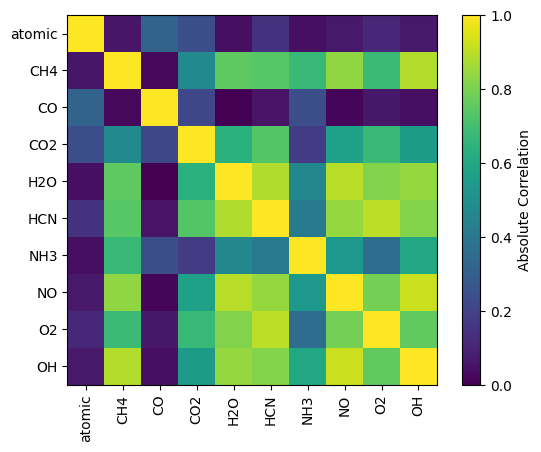

In [13]:
data = []
species = ['atomic', 'CH4', 'CO', 'CO2', 'H2O', 'HCN','NH3', 'NO', 'O2', 'OH']
for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row[f'FLiTs {specie} Wavelength'], row[f'FLiTs {specie} Flux']))
    data.append(fluxes)
df_FLiTs_flux = pd.DataFrame(data, columns=species)
print(df_FLiTs_flux.corr(method='kendall').round(2))
plt.imshow(abs(df_FLiTs_flux.corr(method='kendall')), cmap=plt.get_cmap("viridis")) # method='kendall'
plt.xticks(ticks=np.arange(len(species)), labels=species, rotation=90)
plt.yticks(ticks=np.arange(len(species)), labels=species)
plt.colorbar(label='Absolute Correlation')
plt.show()

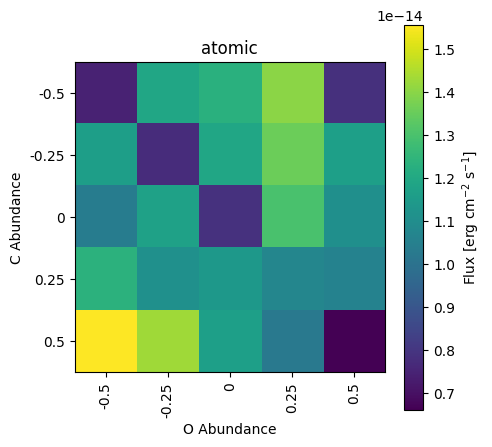

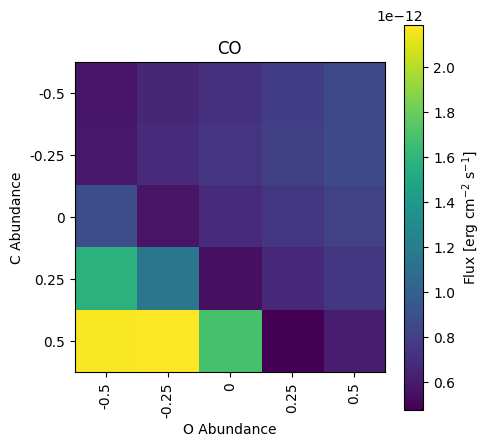

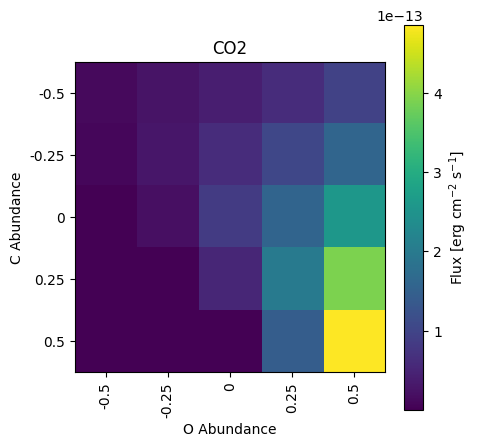

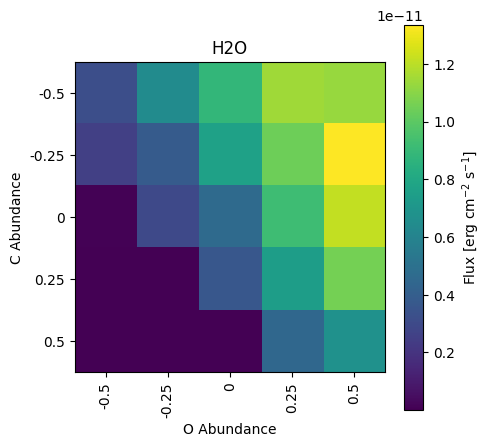

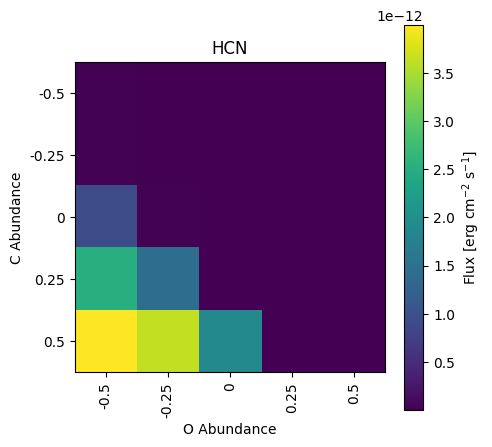

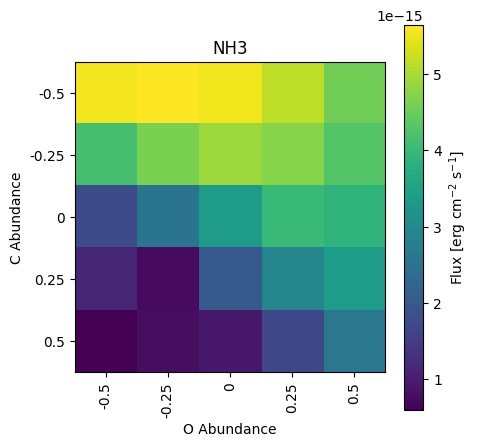

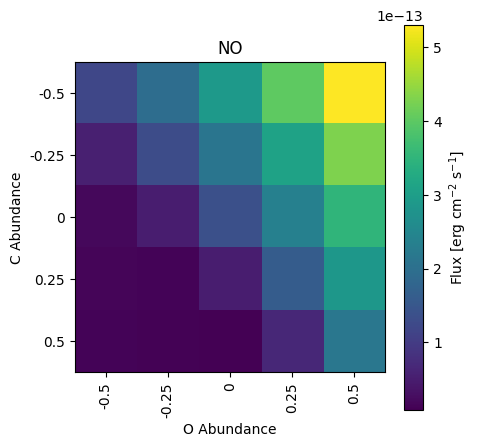

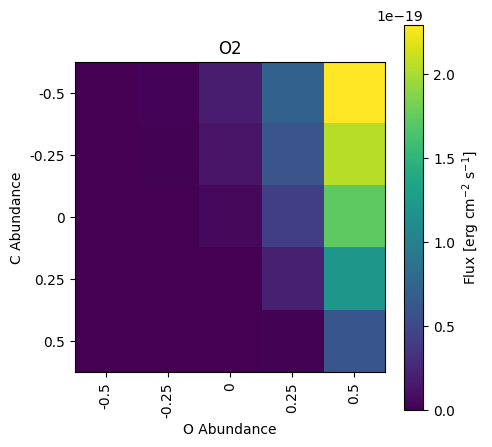

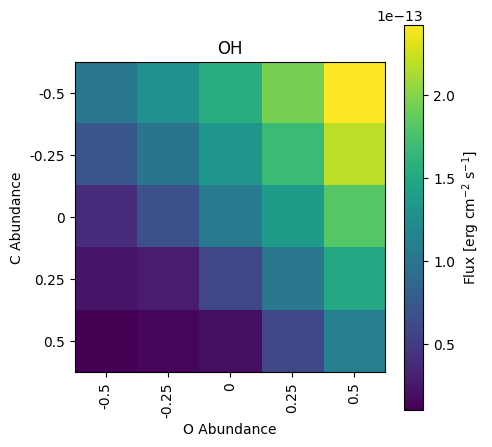

In [14]:
species = ['atomic','NH3']
species = ['atomic', 'CO', 'CO2', 'H2O', 'HCN','NH3', 'NO', 'O2', 'OH']
for specie in species:
    plt.figure(figsize=(5, 5))
    plt.imshow(df_FLiTs_flux[specie].values.reshape(5,5), cmap='viridis')
    plt.title(specie)
    plt.xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    plt.yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
    plt.xlabel('O Abundance')
    plt.ylabel('C Abundance')
    plt.colorbar(label='Flux [erg cm$^{-2}$ s$^{-1}$]')
    # plt.savefig(f'Flux_{specie}.png')
    plt.show()

            atomic   CH4    CO   CO2   H2O   HCN   NH3    NO    O2    OH  ...  \
atomic        1.00  0.06  0.32 -0.24 -0.04  0.15 -0.04 -0.07 -0.11 -0.07  ...   
CH4           0.06  1.00  0.02 -0.47 -0.75  0.74 -0.67 -0.83 -0.68 -0.89  ...   
CO            0.32  0.02  1.00 -0.21  0.00  0.05 -0.24  0.01  0.06  0.04  ...   
CO2          -0.24 -0.47 -0.21  1.00  0.64 -0.73  0.17  0.57  0.67  0.55  ...   
H2O          -0.04 -0.75  0.00  0.64  1.00 -0.88  0.47  0.89  0.81  0.84  ...   
HCN           0.15  0.74  0.05 -0.73 -0.88  1.00 -0.41 -0.84 -0.90 -0.81  ...   
NH3          -0.04 -0.67 -0.24  0.17  0.47 -0.41  1.00  0.53  0.36  0.60  ...   
NO           -0.07 -0.83  0.01  0.57  0.89 -0.84  0.53  1.00  0.79  0.92  ...   
O2           -0.11 -0.68  0.06  0.67  0.81 -0.90  0.36  0.79  1.00  0.76  ...   
OH           -0.07 -0.89  0.04  0.55  0.84 -0.81  0.60  0.92  0.76  1.00  ...   
atomic/CO     0.07 -0.24 -0.61  0.19  0.26 -0.18  0.29  0.21  0.06  0.19  ...   
atomic/CO2    0.29  0.45  0.

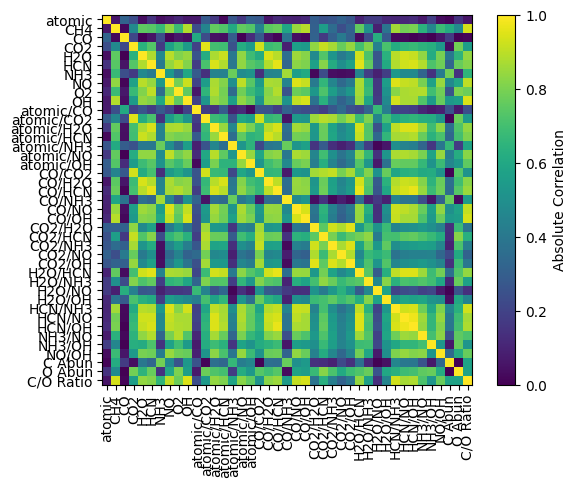

In [15]:
species = ['atomic', 'CO', 'CO2', 'H2O', 'HCN','NH3', 'NO', 'OH']

for index, specie_1 in enumerate(species):
    for specie_2 in species[index+1:]:
        df_FLiTs_flux[f'{specie_1}/{specie_2}'] =df_FLiTs_flux[specie_1]/df_FLiTs_flux[specie_2]
df_FLiTs_flux['C Abun'] = df['C Value'].astype(float)
df_FLiTs_flux['O Abun'] = df['O Value'].astype(float)
df_FLiTs_flux['C/O Ratio'] = df['CO Value'].astype(float)
print(df_FLiTs_flux.corr(method='kendall').round(2))
plt.imshow(abs(df_FLiTs_flux.corr(method='kendall')), cmap=plt.get_cmap("viridis")) # method='kendall'
plt.xticks(ticks=np.arange(len(df_FLiTs_flux.columns)), labels=df_FLiTs_flux.columns, rotation=90)
plt.yticks(ticks=np.arange(len(df_FLiTs_flux.columns)), labels=df_FLiTs_flux.columns)
plt.colorbar(label='Absolute Correlation')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz
import graphviz

X = df_FLiTs_flux.iloc[:, 9:-3]
Y = df_FLiTs_flux.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
model = DecisionTreeRegressor(max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Training MSE: {mean_squared_error(y_train, model.predict(X_train))}")
print(f"Testing MSE: {mean_squared_error(y_test, y_pred)}")


dot_data = export_graphviz(model, out_file=None, feature_names=X_train.columns,  
                           filled=True, rounded=False, special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render("decision_tree")
graph.view()

In [ ]:
specie = 'C/O Ratio'
norm = plt.Normalize(df_FLiTs_flux[specie].min(), df_FLiTs_flux[specie].max())
norm = plt.Normalize(0, 1)
cmap = plt.cm.viridis
columns = df_FLiTs_flux.columns

# Plot each column with colors based on the last column
fig, ax = plt.subplots(figsize=(8, 5))

for i, row in df_FLiTs_flux.iterrows():
    ax.scatter(np.arange(len(columns[:9])), row[0:9], color=cmap(norm(row[specie])), alpha=0.9, s=30)

ax.set_xticks(np.arange(len(columns[:9])))
ax.set_xticklabels(columns[:9]) 
ax.set_yscale('log')
# Formatting
# ax.set_xlabel('Index')
ax.set_ylabel(r'Flux [erg cm$^{-2}$ s$^{-1}$)]')
# plt.title('Plot with Colormap Based on Last Column')
# plt.legend()
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('C/O')

plt.show()

In [33]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

species = ['atomic', 'CO', 'CO2', 'H2O', 'HCN','NH3', 'NO', 'OH']
for specie in species:
    for i in range(25):
        wl=df[f'FLiTs {specie} Wavelength'][i]
        flux=df[f'FLiTs {specie} Flux'][i]
        specR = 3000
        
        # Make a new wl grid
        wl_log=np.logspace(np.log10(np.nanmin(wl)),np.log10(np.nanmax(wl)),num=np.size(wl)*1)
        
        # Find stddev of Gaussian kernel for smoothing
        # taken from here https://github.com/spacetelescope/pysynphot/issues/78
        R_grid=(wl_log[1:-1]+wl_log[0:-2])/(wl_log[1:-1]-wl_log[0:-2])/2
        sigma=np.median(R_grid)/specR
        if sigma<1:
          sigma=1
        
        # Interpolate on logarithmic grid
        f_log=np.interp(wl_log,wl,flux)
        # f_cont_log=np.interp(wl_log,wl,flux_cont)
        
        # in the idl script this is interpreted as the FWHM,
        # but the convolution routine wants stddev use relation
        # FWHM=2*sqrt(2ln2)*stddev=2.355/stddev
        # this should than be consistent with the result from the
        # ProDiMo idl script
        gauss=Gaussian1DKernel(stddev=sigma/2.355)
        flux_conv=convolve_fft(f_log,gauss)
        # flux_cont_conv=convolve_fft(f_cont_log,gauss)
        
        # Interpolate back on original wavelength grid
        flux_sm=np.interp(wl,wl_log,flux_conv)
        # flux_cont_sm=np.interp(wl,wl_log,flux_cont_conv)
        
        cut=2*int(sigma)
        flux_smc=flux_sm[cut:(len(flux_sm)-cut)]
        # flux_cont_smc=flux_cont_sm[cut:(len(flux_cont_sm)-cut)]
        wlc=wl[cut:(len(wl)-cut)]
        
        df[f'FLiTs {specie} Wavelength'][i] = wlc
        df[f'FLiTs {specie} Flux'][i] = flux_smc


C:\Users\niels\AppData\Local\Temp\ipykernel_15056\2768222031.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[f'FLiTs {specie} Flux'][i] = flux_smc
C:\Users\niels\AppData\Local\Temp\ipykernel_15056\2768222031.py:43: FutureWarning: Cha

In [44]:
with open('ModelData.pkl', 'wb') as f:
    pickle.dump(df, f)